In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.transforms import (
    MonotonicAffineTransform,
    MonotonicRQSTransform,
)
from zuko.flows import UnconditionalDistribution
from torch.distributions import Cauchy, Normal, Laplace, Bernoulli, Uniform
from causalflows.flows import CausalFlow
import copy
from ssvkernel import ssvkernel
import numpy as np
from scipy.stats import betaprime, norm

In [2]:
# ---------------- helper: draw |NBP(0.1,0.1)| ---------
def draw_abs_nbp(size):
    """
    |NBP(0.1,0.1)|  where  NB P  is  Normal–Beta-Prime:
      τ   ~ BetaPrime(0.1, 0.1)
      V|τ ~ N(0, τ)
      return |V|
    """
    τ   = betaprime.rvs(0.1, 0.1, size=size)
    v   = norm.rvs(scale=np.sqrt(τ))
    return np.abs(v)

class MixedTails:

    def __init__(self,):
        return

    def sample(self, size):
        b = Bernoulli(1/2).sample(size)
        u1 = Normal(0,1).sample(size).abs()
        u2 = torch.tensor(draw_abs_nbp(size))
        return u1*b - u2*(1-b)
    

# ── Data ─────────────────────────────────────────────────────
seed = 0
torch.manual_seed(seed)
N_train = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Y0 = MixedTails().sample((N_train,1)).to(device)
Y1 = 2*Y0

# ── Build base and transforms ───────────────────────────────
d = 1   # dim(Y)
# two bases (here both Gaussian; you could swap in Laplace etc.)
base0 = UnconditionalDistribution(Normal, loc=torch.zeros(d), scale=torch.ones(d), buffer=True)
base1 = UnconditionalDistribution(Normal, loc=torch.zeros(d), scale=torch.ones(d), buffer=True)

# transform
maf0 = [MaskedAutoregressiveTransform(
            features=1,
            context=0,
            hidden_features=(),
            univariate=MonotonicAffineTransform,
            shapes=[(), ()],
        ),
        MaskedAutoregressiveTransform(
            features=1,
            context=0,
            hidden_features=(),
            univariate=MonotonicRQSTransform,
            shapes=[(8,), (8,), (9,)],
        ),
       MaskedAutoregressiveTransform(
            features=1,
            context=0,
            hidden_features=(),
            univariate=MonotonicAffineTransform,
            shapes=[(), ()],
        ),
    ]
maf1 = [MaskedAutoregressiveTransform(
            features=1,
            context=0,
            hidden_features=(),
            univariate=MonotonicAffineTransform,
            shapes=[(), ()],
        ),
        MaskedAutoregressiveTransform(
            features=1,
            context=0,
            hidden_features=(),
            univariate=MonotonicRQSTransform,
            shapes=[(8,), (8,), (9,)],
        ),
       MaskedAutoregressiveTransform(
            features=1,
            context=0,
            hidden_features=(),
            univariate=MonotonicAffineTransform,
            shapes=[(), ()],
        ),
    ]
# instantiate two flows
flow0 = CausalFlow(transform=maf0, base=base0).to(device)
flow1 = copy.deepcopy(CausalFlow(transform=maf1, base=base1).to(device))

In [7]:
from torch.optim import Adam

# common hyper‐params
lr = 1e-3
batch_size = 128
num_epochs = 1000

# ── DataLoaders ──────────────────────────────────────────────
loader0 = DataLoader(TensorDataset(Y0), batch_size=batch_size, shuffle=True)
loader1 = DataLoader(TensorDataset(Y1), batch_size=batch_size, shuffle=True)

# ── Optimizers ───────────────────────────────────────────────
opt0 = Adam(flow0.parameters(), lr=lr)
opt1 = Adam(flow1.parameters(), lr=lr)

# ── 3) Training loops ─────────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    # train flow0 on Y0
    running0 = 0.0
    for (y_batch,) in loader0:
        y_batch = y_batch.to(device)
        dist0 = flow0()                           # returns a Distribution over Y
        loss0 = -dist0.log_prob(y_batch).mean()   # negative log-likelihood
        opt0.zero_grad()
        loss0.backward()
        opt0.step()
        running0 += loss0.item() * y_batch.size(0)
        
    # train flow1 on Y1
    running1 = 0.0
    for (y_batch,) in loader1:
        y_batch = y_batch.to(device)
        dist1 = flow1()
        loss1 = -dist1.log_prob(y_batch).mean()
        opt1.zero_grad()
        loss1.backward()
        opt1.step()
        running1 += loss1.item() * y_batch.size(0)

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | flow0 NLL = {running0/N_train:.3f} | flow1 NLL = {running1/N_train:.3f}")


KeyboardInterrupt: 

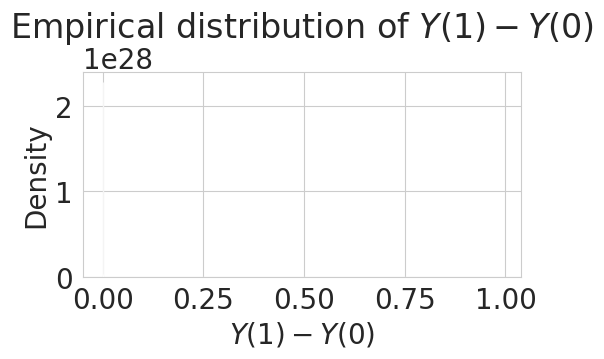

In [6]:
# ── 4) Paired sampling via reseeding ──────────────────────────────────────────
torch.manual_seed(0)
N_effect = 100000
dist0 = flow0()
with torch.no_grad():
    u = dist0.base.sample((N_effect,1))
    Y0_eff = dist0.transform.inv(u).cpu().squeeze()
dist1 = flow1()
with torch.no_grad():
    Y1_eff = dist1.transform.inv(u).cpu().squeeze()

delta = (Y1_eff - Y0_eff)
Y0 = MixedTails().sample((N_effect,)).to(device)
Y1 = Y0*2
true_delta = Y1-Y0

def t(x):
    return torch.sigmoid(x)

# ── 5) Plot empirical histogram of ΔY ────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.hist(t(true_delta), bins=50, density=True, alpha=0.8)
plt.hist(t(delta), bins=50, density=True, alpha=0.8)
plt.title("Empirical distribution of $Y(1)-Y(0)$")
plt.xlabel("$Y(1)-Y(0)$")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [5]:
# ---------- plot ----------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import norm                  # for the true density
from ssvkernel import ssvkernel               # ← same function as before

# ---------- aesthetics (unchanged) ----------
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})
sns.set_style("whitegrid")
col_data, col_true = sns.color_palette("colorblind", 2)

x_grid = np.linspace(0, 1, 200)
y_hat = ssvkernel(t(delta).numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]
y_true = ssvkernel(t(true_delta).numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x_grid, y_hat, color=col_data, lw=10, label="Estimated")
ax.fill_between(x_grid, 0, y_hat, color=col_data, alpha=0.4)
ax.plot(x_grid, y_true, color=col_true, lw=15, ls="--", label="True")
ax.set_ylim(0,4.5)
ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize = 60)
ax.set_ylabel("Density", fontsize = 60)
ax.tick_params(axis='x', labelsize=48)  # or whatever size you want
ax.tick_params(axis='y', labelsize=48)  # or whatever size you want
ax.set_title(r"CNF(G) - Mixed Noise", fontsize=60)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#ax.legend(frameon=False, fontsize=48)
ax.grid(alpha = 0.5)
fig.tight_layout()
fig.savefig("flow_misspec_mixed_g.png", bbox_inches="tight")
plt.show()

/nfs/ghome/live/danceh/Cocycles/misc/ssvkernel.py:322: RuntimeWarning: divide by zero encountered in log
  y[x < 1e2] = np.log(np.exp(x[x < 1e2]) - 1)
/nfs/ghome/live/danceh/.local/mambaforge/envs/cocycles/lib/python3.12/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/nfs/ghome/live/danceh/Cocycles/misc/ssvkernel.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  c[j, :] = yh**2 - 2 * yh * y_hist + 2 / (2 * np.pi)**0.5 / w * y_hist
/nfs/ghome/live/danceh/Cocycles/misc/ssvkernel.py:108: RuntimeWarning: invalid value encountered in multiply
  c[j, :] = yh**2 - 2 * yh * y_hist + 2 / (2 * np.pi)**0.5 / w * y_hist
/nfs/ghome/live/danceh/Cocycles/misc/ssvkernel.py:196: RuntimeWarning: invalid value encountered in divide
  gs = optws[:, k] / WIN


ValueError: zero-size array to reduction operation maximum which has no identity

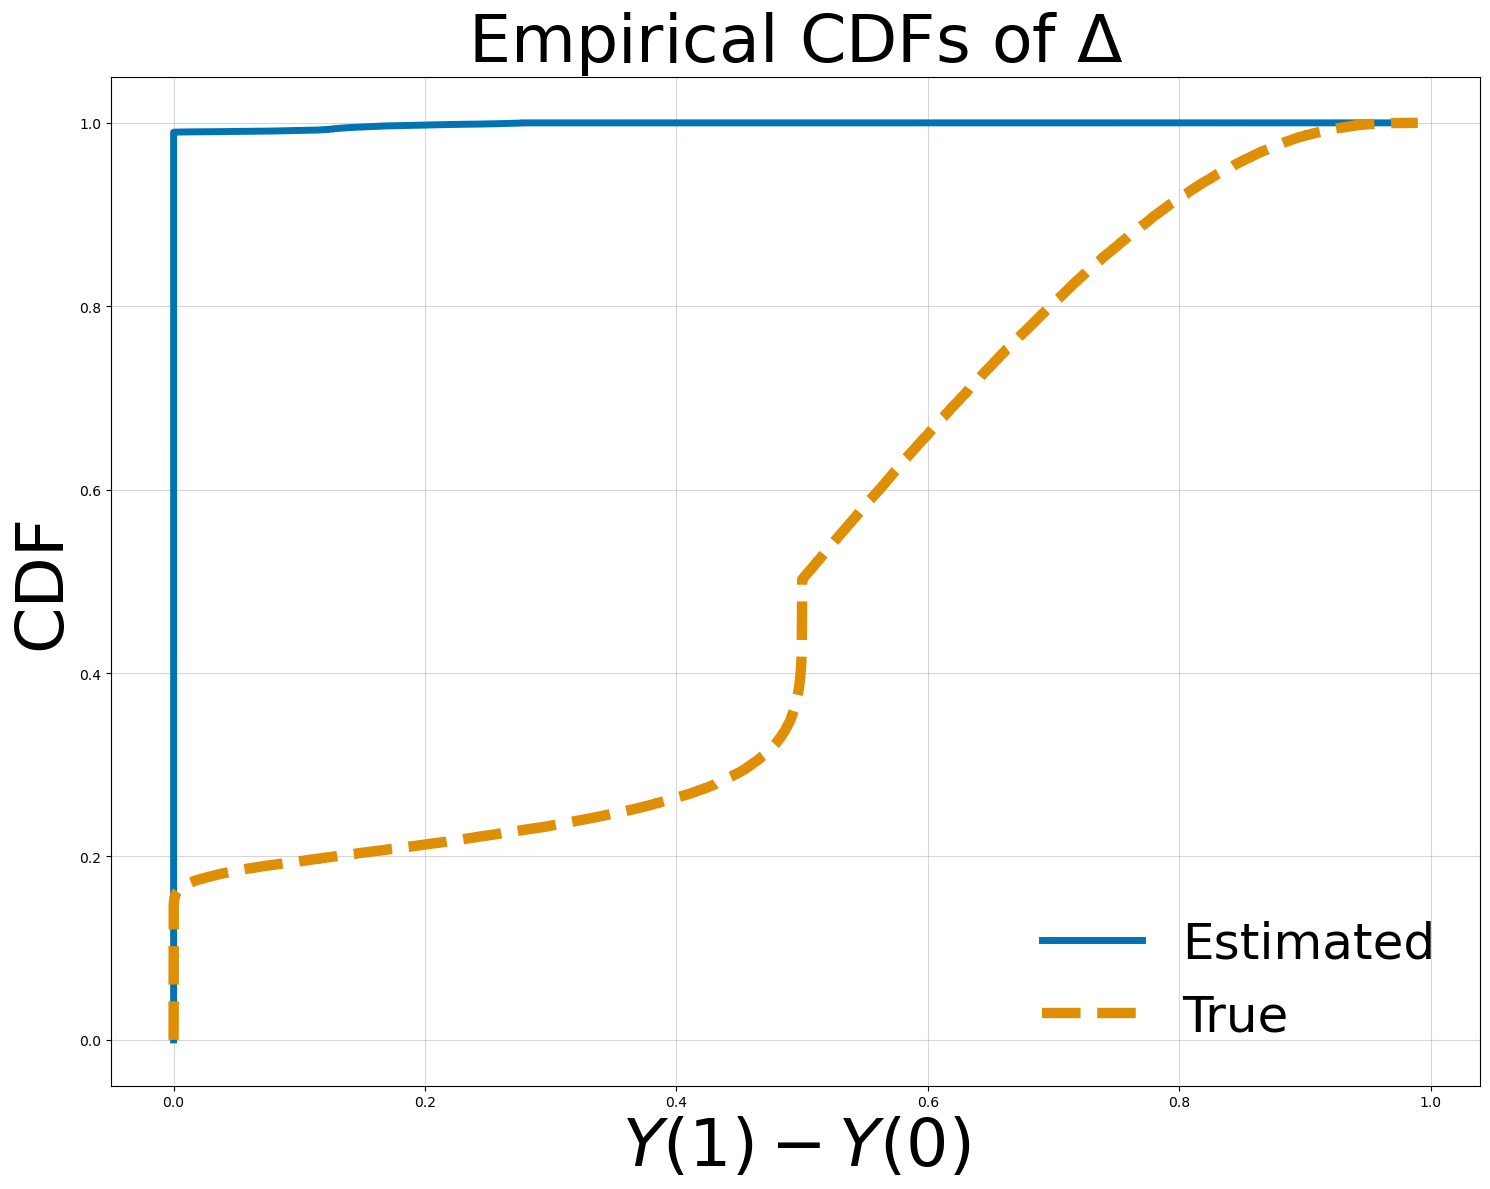

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Sort the data
delta_sorted = np.sort(t(delta))
true_delta_sorted = np.sort(t(true_delta))

# Empirical CDF values
n = len(delta_sorted)
m = len(true_delta_sorted)
cdf_delta = np.linspace(0, 1, n, endpoint=False)
cdf_true = np.linspace(0, 1, m, endpoint=False)

# Colors
col_data, col_true = sns.color_palette("colorblind", 2)

# Plot
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15, 12))

ax.plot(delta_sorted, cdf_delta, color=col_data, lw=5, label="Estimated")
ax.plot(true_delta_sorted, cdf_true, color=col_true, lw=7.5, ls="--", label="True")

ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=48)
ax.set_ylabel("CDF", fontsize=48)
ax.set_title(r"Empirical CDFs of $\Delta$", fontsize=48)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=36)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("cdf_comparison_delta.png", bbox_inches="tight")
plt.show()

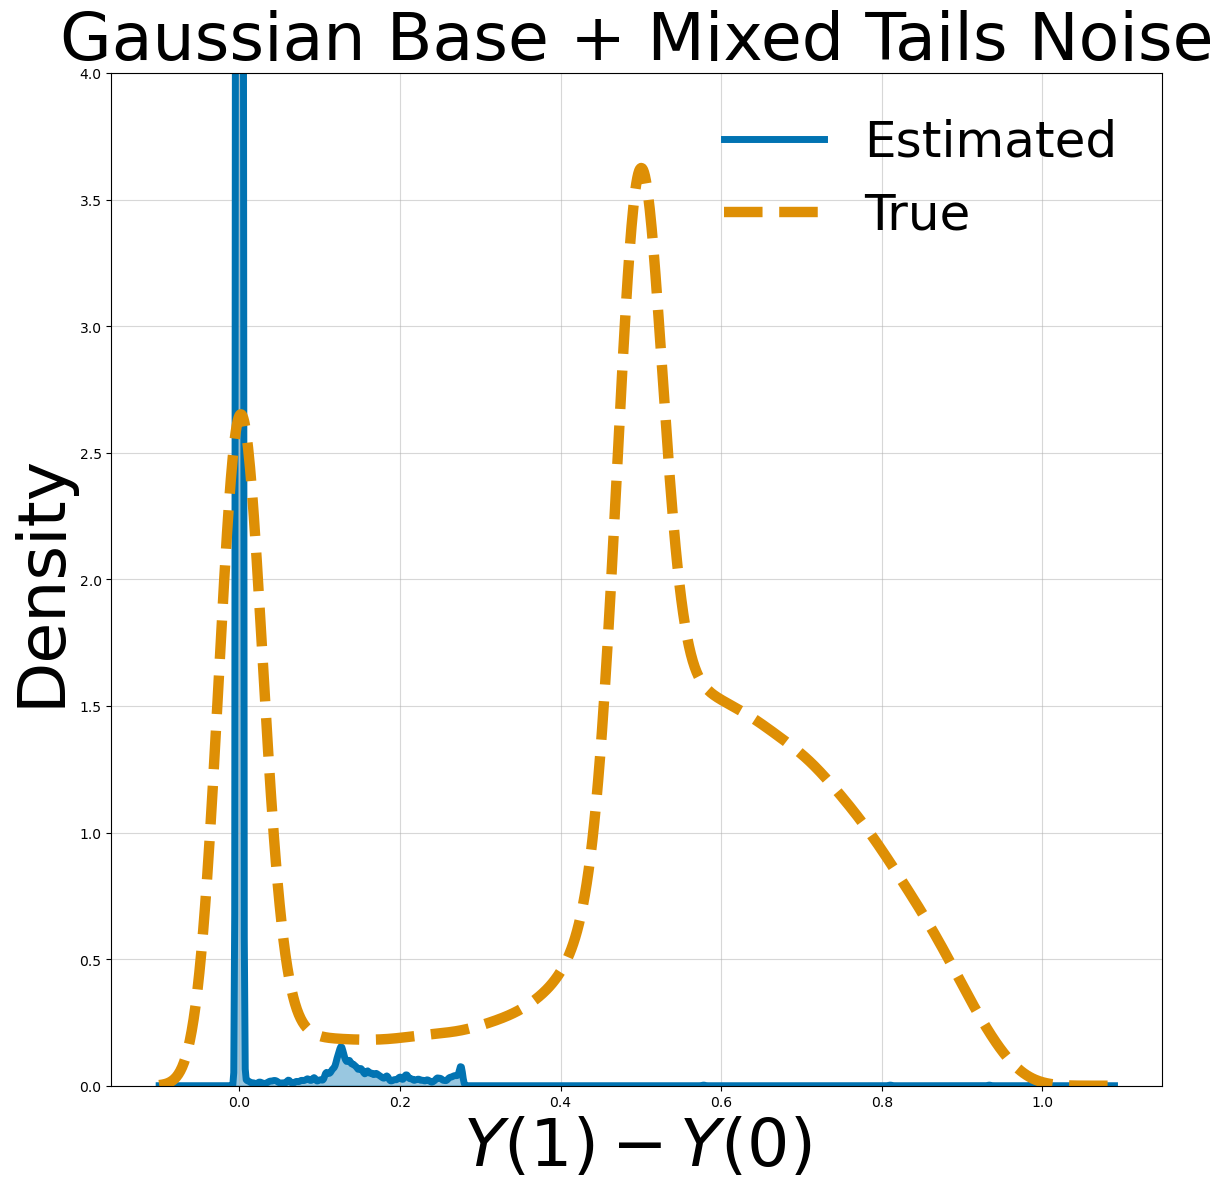

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import gaussian_kde
import seaborn as sns

# Colors
col_data, col_true = sns.color_palette("colorblind", 2)

# KDE grids
x_grid = np.linspace(min(t(delta).min(), t(true_delta).min()) - 0.1,
                     max(t(delta).max(), t(true_delta).max()) + 0.1, 1000)

# KDE estimation
kde_est = gaussian_kde(t(delta))
kde_true = gaussian_kde(t(true_delta))

y_hat = kde_est(x_grid)
y_true = kde_true(x_grid)

# Plot with formatting
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(x_grid, y_hat, color=col_data, lw=5, label="Estimated")
ax.fill_between(x_grid, 0, y_hat, color=col_data, alpha=0.4)
ax.plot(x_grid, y_true, color=col_true, lw=7.5, ls="--", label="True")

ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=48)
ax.set_ylabel("Density", fontsize=48)
ax.set_title(r"Gaussian Base + Mixed Tails Noise", fontsize=48)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=36)
ax.grid(alpha=0.5)
fig.tight_layout()
ax.set_ylim(0,4)
fig.savefig("flow_misspec_mixed_g.png", bbox_inches="tight")
plt.show()